In [255]:
# 패키지 임포트
import os
import numpy as np
import pandas as pd
from pandas import to_datetime
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
import warnings
import datetime
from datetime import datetime
warnings.filterwarnings('ignore')

%matplotlib inline

# ARIMA 모델 패키지
import statsmodels.api as sm


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# Auto Arima 모델 패키지
# pip install --user pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# ARIMA

In [256]:
df = pd.read_excel('/Users/keumhyeonjun/Projects/행안부/자재/GFMS DB/FMSD03_검침실적.xlsx')
df

,comp_cd,ins_day,gag_cd,meter_val,real_meter_val,use_val,use_amt,use_note,ins_max,ins_min,...,meter_val_sm,use_val_am,use_val_pm,use_val_sm,gag_val,input_sysdt,chg_sysdt,input_emp_no,chg_emp_no,input_scr_nm
0,SEJO,2021-10-01,1000,8174.0,8174.0,8.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-01 오전 9:56:58,NaN,2ehd8869,NaN,ENG_B11
1,SEJO,2021-10-05,1000,8180.0,8180.0,6.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-05 오전 10:12:38,NaN,scc2133,NaN,ENG_B11
2,SEJO,2021-10-06,1000,8184.0,8184.0,4.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-06 오전 9:17:52,NaN,scc2133,NaN,ENG_B11
3,SEJO,2021-10-07,1000,8190.0,8190.0,6.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-07 오전 9:40:09,NaN,scc2133,NaN,ENG_B11
4,SEJO,2021-10-08,1000,8197.0,8197.0,7.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-08 오전 9:49:12,NaN,scc2133,NaN,ENG_B11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46345,SEJO,2022-10-04,999,27757.0,27757.0,9.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2022-10-04 오전 10:29:50,NaN,scc2133,NaN,ENG_B11
46346,SEJO,2022-10-05,999,27763.0,27763.0,6.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2022-10-05 오전 9:58:39,NaN,2ehd5808,NaN,ENG_B11
46347,SEJO,2022-10-06,999,27765.0,27765.0,2.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2022-10-06 오전 9:37:06,NaN,1ehd8664,NaN,ENG_B11
46348,SEJO,2022-10-07,999,27771.0,27771.0,6.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2022-10-07 오전 9:47:35,NaN,1ehd8664,NaN,ENG_B11


In [257]:
data = df[['ins_day','gag_cd','use_val']]
forecast_data = data[data['gag_cd']==1000]
forecast_data = forecast_data[(forecast_data['use_val'] >= 0) & (forecast_data['use_val'] <= 100)]
forecast_data = forecast_data[['ins_day','use_val']]

In [258]:
X_train = forecast_data[forecast_data['ins_day'] < '2022-08-01']
X_valid = forecast_data[forecast_data['ins_day'] >= '2022-08-01']
nyc = X_train[['ins_day','use_val']]
nyc_v = X_valid[['ins_day','use_val']]

# 각 데이터의 사이즈 확인하기
print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train Shape (205, 2)
X_Valid Shape (43, 2)


In [259]:
# Date 를 dataframe의 인덱스로 만들어주기
nyc.set_index('ins_day', inplace=True)
nyc_v.set_index('ins_day', inplace=True)

In [260]:
index_predict = to_datetime(nyc_v.index)

# 확인해보기
index_predict

DatetimeIndex(['2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
               '2022-08-05', '2022-08-08', '2022-08-09', '2022-08-10',
               '2022-08-11', '2022-08-12', '2022-08-16', '2022-08-17',
               '2022-08-18', '2022-08-19', '2022-08-22', '2022-08-23',
               '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-29',
               '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-05',
               '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-13',
               '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-19',
               '2022-09-20', '2022-09-21', '2022-09-22', '2022-09-27',
               '2022-09-28', '2022-09-29', '2022-10-01', '2022-10-04',
               '2022-10-05', '2022-10-07', '2022-10-11'],
              dtype='datetime64[ns]', name='ins_day', freq=None)

In [261]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
param_list =[]
param_result_list = []
for param in pdq:
    try:
        model_arima = sm.tsa.arima.ARIMA(nyc,order=param)
        model_arima_fit = model_arima.fit()
        param_list.append(param)
        param_result_list.append(model_arima_fit.aic)
    except:
        continue
idx = param_result_list.index(min(param_result_list))
print(param_list[idx])

(1, 1, 2)


In [262]:
# order 에 파라미터 넣어주기.
model_arima = sm.tsa.arima.ARIMA(nyc, order=param_list[idx])
model_arima_fit = model_arima.fit()

# 예측한 값들을 저장
fcast1 = model_arima_fit.forecast(len(index_predict))
fcast1= pd.DataFrame(fcast1)
fcast1.index = index_predict

3.1537206030013434


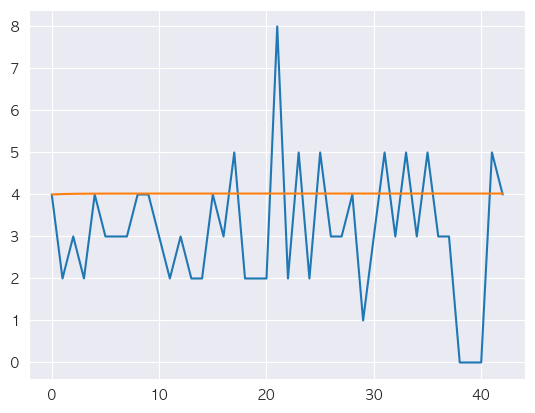

In [263]:
result = pd.concat([pd.DataFrame(nyc_v['use_val'].values),pd.DataFrame(fcast1.values)],axis=1)
result.columns = ['actual','predict']
print(mean_squared_error(result['actual'], result['predict']))
plt.plot(result)

# LGBM

In [264]:
from lightgbm import LGBMRegressor


In [265]:
df

,comp_cd,ins_day,gag_cd,meter_val,real_meter_val,use_val,use_amt,use_note,ins_max,ins_min,...,meter_val_sm,use_val_am,use_val_pm,use_val_sm,gag_val,input_sysdt,chg_sysdt,input_emp_no,chg_emp_no,input_scr_nm
0,SEJO,2021-10-01,1000,8174.0,8174.0,8.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-01 오전 9:56:58,NaN,2ehd8869,NaN,ENG_B11
1,SEJO,2021-10-05,1000,8180.0,8180.0,6.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-05 오전 10:12:38,NaN,scc2133,NaN,ENG_B11
2,SEJO,2021-10-06,1000,8184.0,8184.0,4.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-06 오전 9:17:52,NaN,scc2133,NaN,ENG_B11
3,SEJO,2021-10-07,1000,8190.0,8190.0,6.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-07 오전 9:40:09,NaN,scc2133,NaN,ENG_B11
4,SEJO,2021-10-08,1000,8197.0,8197.0,7.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2021-10-08 오전 9:49:12,NaN,scc2133,NaN,ENG_B11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46345,SEJO,2022-10-04,999,27757.0,27757.0,9.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2022-10-04 오전 10:29:50,NaN,scc2133,NaN,ENG_B11
46346,SEJO,2022-10-05,999,27763.0,27763.0,6.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2022-10-05 오전 9:58:39,NaN,2ehd5808,NaN,ENG_B11
46347,SEJO,2022-10-06,999,27765.0,27765.0,2.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2022-10-06 오전 9:37:06,NaN,1ehd8664,NaN,ENG_B11
46348,SEJO,2022-10-07,999,27771.0,27771.0,6.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,2022-10-07 오전 9:47:35,NaN,1ehd8664,NaN,ENG_B11


In [266]:
#df['ins_day'] = pd.to_datetime(df['ins_day'], format= '%Y-%m-%d %H:%M:%S', errors='raise')
df['ins_day'] = pd.to_datetime(df['ins_day'])
df['year'] = df['ins_day'].dt.year
df['month'] = df['ins_day'].dt.month
df['day'] = df['ins_day'].dt.day
df['weekday'] = df['ins_day'].dt.weekday
dataset = df[['gag_cd','year','month','day','weekday','use_val']]
dataset = dataset[(dataset['use_val'] >= -100) & (dataset['use_val'] <= 100)]

dataset = dataset[dataset['gag_cd']==1000]

X = dataset.drop('use_val',axis = 1)
y = dataset['use_val']

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [268]:
model = LGBMRegressor()
model.fit(X_train, y_train, categorical_feature =['gag_cd'], verbose=100)

LGBMRegressor()

In [269]:
y_predict = model.predict(X_test)
y_predict = pd.DataFrame(y_predict)
result = X_test.reset_index()
result = pd.concat([result, y_test.reset_index(),y_predict], axis=1)
mean_squared_error(result['use_val'], result[0])

10.040001272071867

In [270]:
mean_squared_error(result['use_val'], result[0])

10.040001272071867

In [271]:
result[0].describe()

count    82.000000
mean      4.488796
std       0.754360
min       2.704667
25%       4.013783
50%       4.409029
75%       4.816672
max       5.937706
Name: 0, dtype: float64

In [272]:
result['use_val'].describe()

count    82.000000
mean      4.134146
std       3.126005
min       0.000000
25%       3.000000
50%       4.000000
75%       5.000000
max      27.000000
Name: use_val, dtype: float64